In [22]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import random
from scipy.spatial.distance import cdist
from sklearn.decomposition import PCA
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.cm as cm
from matplotlib.animation import FuncAnimation
from IPython.display import Image
import os
from scipy.sparse import csr_matrix

In [23]:
def CentNN(X, n_clusters, epsilon = 0.05):
    X =  np.where(np.isnan(X), 0, X)
    centroid_X = np.mean(X, axis=0)
    w = [centroid_X + epsilon, centroid_X - epsilon]
    cluster_members = [[], []]
    cluster_indices = []

    for i, x in enumerate(X):
        distances = cdist([x], w ,'euclidean')[0]
        index = np.argmin(distances)
        cluster_indices.append(index)
        w[index] = w[index] + 1/(1+len(cluster_members[index]))*(x - w[index])
        cluster_members[index].append(x)

    epoch = 0
    loser = 0
    while True:
        while True:
            loser = 0

            for i in range(len(X)):
                x = X[i]
                distances = cdist([x], w ,'euclidean')[0]
                current_cluster_index = np.argmin(distances)
                previous_cluster_index = cluster_indices[i]

                if previous_cluster_index != current_cluster_index: 
                    w[current_cluster_index] = w[current_cluster_index] + (x - w[current_cluster_index])/(len(cluster_members[current_cluster_index])+1)
                    w[previous_cluster_index] = w[previous_cluster_index] - (x - w[previous_cluster_index])/(len(cluster_members[previous_cluster_index])-1)   
                    cluster_members[current_cluster_index] = list(cluster_members[current_cluster_index])
                    cluster_members[current_cluster_index].append(x)

                    ind = 0
                    size = len(cluster_members[previous_cluster_index])
                    while ind != size and not np.array_equal(cluster_members[previous_cluster_index][ind],x):
                        ind += 1
                    if ind != size:
                        cluster_members[previous_cluster_index].pop(ind)
                    else:
                        raise ValueError('array not found in list.')

                    cluster_indices[i] = current_cluster_index
                    loser += 1
            if loser == 0:
                break

            epoch += 1

        if len(w) != n_clusters:
            all_error = []
            for i in range(len(w)):
                dists = cdist([w[i]], cluster_members[i], 'euclidean')[0]
                error = np.sum(dists)
                all_error.append(error)

            new_w = w[np.argmax(all_error)] + epsilon
            w.append(new_w)

            cluster_members.append(np.array([]))
        else:
            break
    
    return cluster_members, np.array(w) 

In [24]:
def KMeans(X, n_clusters):
    X =  np.where(np.isnan(X), 0, X)
    centroids = [X[i] for i in random.sample(range(0, len(X)), n_clusters)]
    clusters = [[] for _ in range(n_clusters)]

    for x in X:
        min_dist = float('inf')
        closest_centroid = None
        for j, centroid in enumerate(centroids):
            dist = cdist([x], [x], 'euclidean')[0]
            if dist < min_dist:
                min_dist = dist
                closest_centroid = j
                
        clusters[closest_centroid].append(x)

    diff = 1
    iteration = 0
    while diff > 0 and iteration < 100:
        iteration += 1
        diff = 0
        centroids = [np.mean(cluster, axis=0) if cluster else random.choice(X) for cluster in clusters]
        new_clusters = [[] for _ in range(n_clusters)]

        for i, cluster in enumerate(clusters):
            for point in cluster:
                min_dist = float('inf')
                closest_centroid = None
                for j, centroid in enumerate(centroids):
                    dist = cdist([point], [centroid], 'euclidean')[0]
                    if dist < min_dist:
                        min_dist = dist
                        closest_centroid = j
                
                if closest_centroid != i:
                    diff += 1
                
                new_clusters[closest_centroid].append(point)
        
        clusters = new_clusters
    
    return clusters, centroids

In [25]:
def replace_quotes(file_path):
    try:
        with open(file_path, 'r') as file:
            content = file.read()
        
        # Replace \" with ""
        modified_content = content.replace('\\"', '""')
        
        with open(file_path, 'w') as file:
            file.write(modified_content)
        
    except FileNotFoundError:
        print(f'File not found: {file_path}')
    except Exception as e:
        print(f'Error occurred: {e}')

In [26]:
def delete_book(ISBN_to_delete, ratings_df):
    return ratings_df[ratings_df['ISBN'] != ISBN_to_delete]

In [27]:
books_file = 'books-data/Books.csv'
users_file = 'books-data/Users.csv'
ratings_file = 'books-data/Book-Ratings.csv'

#replace_quotes(books_file)
books_df = pd.read_csv(books_file, encoding = "ISO-8859-1", sep=";", on_bad_lines="skip")
users_df = pd.read_csv(users_file, encoding = "ISO-8859-1", sep=";")
ratings_df = pd.read_csv(ratings_file, encoding = "ISO-8859-1", sep=";")
ratings_df = delete_book("0679781587", ratings_df)

min_user_ratings_values = [50,100,150]
min_book_ratings_values = [50,100,150]

user_counts = ratings_df['User-ID'].value_counts()
valid_users = user_counts[user_counts >= min_user_ratings_values[-1]].index.tolist()
selected_ratings_df = ratings_df[ratings_df['User-ID'].isin(valid_users)]

book_counts = selected_ratings_df['ISBN'].value_counts()
valid_books = book_counts[book_counts >= min_book_ratings_values[-1]].index.tolist()
selected_ratings_df = selected_ratings_df[selected_ratings_df['ISBN'].isin(valid_books)]

user_book_ratings = selected_ratings_df.pivot_table(index='User-ID', columns='ISBN', values='Book-Rating')

removed_rows = 0
def values_nan_or_zero(row):
    global removed_rows
    row = np.where(np.isnan(row), 0, row)
    if (row == 0).all():
        removed_rows += 1

    return not (row == 0).all()

user_book_ratings = user_book_ratings[user_book_ratings.apply(values_nan_or_zero, axis=1)]
users = np.random.choice(user_book_ratings.index, 10, replace=False)

print("Number of removed rows:", removed_rows)
for user in users:
    print(f"User id: {user}")

C:\Users\Admin\AppData\Local\Temp\ipykernel_17392\1022132638.py:6: DtypeWarning: Columns (3) have mixed types. Specify dtype option on import or set low_memory=False.
  books_df = pd.read_csv(books_file, encoding = "ISO-8859-1", sep=";", on_bad_lines="skip")


Number of removed rows: 323
User id: 124363
User id: 6543
User id: 255092
User id: 59150
User id: 124942
User id: 92405
User id: 156467
User id: 92810
User id: 32440
User id: 158254


In [28]:
def get_pivot_table(min_user_ratings, min_book_ratings):
    user_counts = ratings_df['User-ID'].value_counts()
    valid_users = user_counts[user_counts >= min_user_ratings].index.tolist()
    selected_ratings_df = ratings_df[ratings_df['User-ID'].isin(valid_users)]

    book_counts = selected_ratings_df['ISBN'].value_counts()
    valid_books = book_counts[book_counts >= min_book_ratings].index.tolist()
    selected_ratings_df = selected_ratings_df[selected_ratings_df['ISBN'].isin(valid_books)]
    
    user_book_ratings = selected_ratings_df.pivot_table(index='User-ID', columns='ISBN', values='Book-Rating')
    
    def values_nan_or_zero(row):
        row = np.where(np.isnan(row), 0, row)
        return not (row == 0).all()

    user_book_ratings = user_book_ratings[user_book_ratings.apply(values_nan_or_zero, axis=1)]

    return user_book_ratings

In [29]:
def make_recommendation(centroids):
    user_recommendations = {}    

    for user_id in users:
        print(f"User {user_id}:")

        user_ratings = user_book_ratings.loc[user_id].values.reshape(1, -1)

        nan_ratings = np.isnan(user_ratings)
        nan_indices = np.where(nan_ratings)[1]

        user_ratings_without_nan = np.where(np.isnan(user_ratings), 0, user_ratings)

        closest_centroid = None
        min_dist = float('inf')
        index = 0
        for i, centroid in enumerate(centroids):
            dist = cdist(user_ratings_without_nan, np.array([centroid]), 'euclidean')[0]
            if dist < min_dist:
                min_dist = dist
                closest_centroid = centroid
                index = i
        print("Closest centroid: ", index)
        
        recommended_books_rating = np.array([])
        recommended_books_ISBN = np.array([])
        for index in nan_indices:
            recommended_books_rating = np.append(recommended_books_rating, closest_centroid[index])
            recommended_books_ISBN = np.append(recommended_books_ISBN, user_book_ratings.columns[index])

        sorted_indices = np.argsort(recommended_books_rating)[::-1]

        sorted_recommended_books_rating = recommended_books_rating[sorted_indices]
        sorted_recommended_books_ISBN = recommended_books_ISBN[sorted_indices]

        best_books_rating = sorted_recommended_books_rating[:10]
        best_books_ISBN = sorted_recommended_books_ISBN[:10]
            
        best_books_names = np.array([])
        for ISBN in best_books_ISBN:
            best_books_names = np.append(best_books_names, books_df[books_df['ISBN'] == ISBN].values[0][1])

        print(';\n'.join(str(b) for b in best_books_names))

        user_recommendations[user_id] = {'best_books_rating': best_books_rating, 'best_books_names': best_books_names}
    
    return user_recommendations

In [30]:
def plot_clusters(clusters, centroids):
    flattened_clusters = np.vstack([cluster for cluster in clusters])
    flattened_clusters_with_centroids = np.vstack([flattened_clusters, centroids])

    pca = PCA(n_components=3)
    pca_result = pca.fit_transform(flattened_clusters_with_centroids)

    all_clusters_pca = pca_result[:-len(centroids)]
    centroids_pca = pca_result[-len(centroids):] 
    clusters_pca = []

    index = 0
    for i in range(len(clusters)):
        clusters_pca.append([])
        for j in range(len(clusters[i])):
            clusters_pca[i].append(all_clusters_pca[index])
            index += 1

    fig = plt.figure()
    ax = fig.add_subplot(111, projection='3d')
    cm = plt.get_cmap('gist_rainbow')
    colors = [cm(1.*i/len(clusters_pca)) for i in range(len(clusters_pca))]
    for i in range(len(centroids_pca)):
        ax.scatter(centroids_pca[i][0], centroids_pca[i][1], centroids_pca[i][2], color=colors[i], marker='^', s=100)
        for point in clusters_pca[i]:
            ax.scatter(point[0], point[1], point[2], color=colors[i])

    ax.set_xlabel('PCA Component 1')
    ax.set_ylabel('PCA Component 2')
    ax.set_zlabel('PCA Component 3')
    ax.set_title('Cluster Plot with PCA (3D)')
    plt.show()

In [31]:
def plot_all_recommendations(all_recommendations):
    users = list(all_recommendations[(min_user_ratings_values[0], min_book_ratings_values[0])].keys())
    sets = list(all_recommendations.keys())
    ratings = [all_recommendations[s][user]['best_books_rating'] for s in sets for user in users]
    books = [all_recommendations[s][user]['best_books_names'] for s in sets for user in users]

    unique_books = list(set([book for sublist in books for book in sublist]))
    cm = plt.get_cmap('gist_rainbow')
    colors = [cm(1.*i/len(unique_books)) for i in range(len(unique_books))]
    book_color_map = {book: color for book, color in zip(unique_books, colors)}

    fig = plt.figure()
    ax = fig.add_subplot(111, projection='3d')

    ax.set_ylabel('(min_user_ratings, min_book_ratings)')
    ax.set_zlabel('Rating (0-10)')

    ax.set_xticks(range(len(sets)))
    ax.set_xticklabels(sets)

    ax.set_yticks(range(len(users)))
    ax.set_yticklabels(users)

    books_ratings = [(book, user_data['best_books_rating']) for s in all_recommendations for user_data in all_recommendations[s].values() for book in user_data['best_books_names']]
    ratings_data = [rating for _, ratings in books_ratings for rating in ratings]

    ax.set_zlim(0, 10)
    ax.set_zticks(np.linspace(0, 10, 11))
    ax.set_zticklabels(np.linspace(0, 10, 11))

    for x, (set_val, users_data) in enumerate(all_recommendations.items()):
        for y, (user, user_data) in enumerate(users_data.items()):
            names, ratings = user_data['best_books_names'], user_data['best_books_rating']
            for name, rating in zip(names, ratings):
                ax.scatter(x, y, rating, color=book_color_map[name])

    plt.show()

In [32]:
def plot_recommendations_for_users(all_recommendations):
    users = list(all_recommendations[(min_user_ratings_values[0], min_book_ratings_values[0])].keys())
    sets = list(all_recommendations.keys())
    ratings = [all_recommendations[s][user]['best_books_rating'] for s in sets for user in users]
    books = [all_recommendations[s][user]['best_books_names'] for s in sets for user in users]

    unique_books = list(set(book for users_data in all_recommendations.values() for user_data in users_data.values() for book in user_data['best_books_names']))
    colors = cm.rainbow(np.linspace(0, 1, len(unique_books)))
    book_color_map = {book: color for book, color in zip(unique_books, colors)}

    fig, axs = plt.subplots(len(users), 1, figsize=(8, 6 * len(users)))

    for user_index, user in enumerate(users):
        for set_val_index, set_val in enumerate(sets):
            x_val = set_val_index + 1 
            ratings = all_recommendations[set_val][user]['best_books_rating']
            names = all_recommendations[set_val][user]['best_books_names']

            for book_index, (rating, name) in enumerate(zip(ratings, names)):
                axs[user_index].scatter(x_val, rating, color=book_color_map[name], label=name)

            axs[user_index].set_title(f'Ratings for User {user}')
            axs[user_index].set_ylabel('Rating (0-10)')
            axs[user_index].set_xlabel('Sets (min_user_rating, min_book_rating)')
            axs[user_index].set_xticks(range(1, len(sets) + 1))
            axs[user_index].set_xticklabels([f"({s[0]}, {s[1]})" for s in sets], rotation=45, ha='right')
            axs[user_index].set_ylim(-0.5, 11)
            
    plt.tight_layout()
    plt.subplots_adjust(top=0.92)
    plt.show()

In [33]:
def plot_recommendations_for_sets(all_recommendations):
    users = list(all_recommendations[(min_user_ratings_values[0], min_book_ratings_values[0])].keys())
    sets = list(all_recommendations.keys())
    unique_books = list(set(book for users_data in all_recommendations.values() for user_data in users_data.values() for book in user_data['best_books_names']))
    colors = plt.cm.rainbow(np.linspace(0, 1, len(unique_books)))
    book_color_map = {book: color for book, color in zip(unique_books, colors)}

    fig, axs = plt.subplots(len(sets), 1, figsize=(8, 6 * len(sets)))

    for set_index, set_val in enumerate(sets):
        for user_index, user in enumerate(users):
            ratings = all_recommendations[set_val][user]['best_books_rating']
            names = all_recommendations[set_val][user]['best_books_names']

            x_vals = np.full(len(ratings), user_index + 1)
            y_vals = ratings

            for x_val, y_val, name in zip(x_vals, y_vals, names):
                axs[set_index].scatter(x_val, y_val, color=book_color_map[name], label=name)

            axs[set_index].set_title(f'Ratings for Set {set_val}')
            axs[set_index].set_ylabel('Rating (0-10)')
            axs[set_index].set_xlabel('Users')
            axs[set_index].set_xticks(range(1, len(users) + 1))
            axs[set_index].set_xticklabels(users)
            axs[set_index].set_ylim(-0.5, 11)

    plt.subplots_adjust(top=0.92)
    plt.show()


Predictions for min_user_ratings = 50, min_book_ratings = 50
ISBN     002026478X  002542730X  0060008032  0060085444  0060096195  \
User-ID                                                               
243             NaN         NaN         NaN         NaN         NaN   
254             NaN         NaN         NaN         NaN         NaN   
507             NaN         NaN         NaN         NaN         NaN   
638             NaN         NaN         NaN         NaN         NaN   
643             NaN         NaN         NaN         NaN         NaN   
...             ...         ...         ...         ...         ...   
278188          NaN         NaN         NaN         NaN         NaN   
278418          NaN         NaN         NaN         NaN         NaN   
278582          NaN         NaN         NaN         NaN         NaN   
278633          NaN         NaN         NaN         NaN         NaN   
278843          NaN         NaN         NaN         NaN         NaN   

ISBN     00601

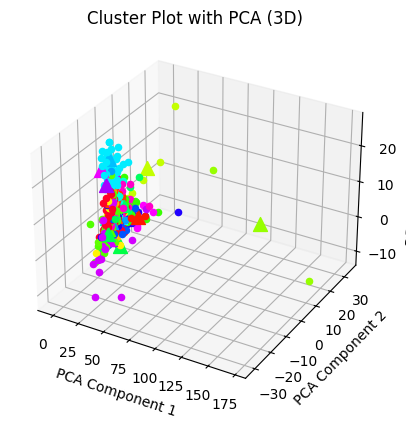

User 124363:
Closest centroid:  97
Watership Down;
The Lovely Bones: A Novel;
Fahrenheit 451;
A Prayer for Owen Meany;
Lolita (Vintage International);
Life of Pi;
Anne Frank: The Diary of a Young Girl;
Ender's Game (Ender Wiggins Saga (Paperback));
Into Thin Air : A Personal Account of the Mt. Everest Disaster;
To Kill a Mockingbird
User 6543:
Closest centroid:  97
Watership Down;
A Prayer for Owen Meany;
Lolita (Vintage International);
Anne Frank: The Diary of a Young Girl;
Life of Pi;
Ender's Game (Ender Wiggins Saga (Paperback));
Ella Minnow Pea: A Novel in Letters;
A Patchwork Planet;
To Kill a Mockingbird;
Into Thin Air : A Personal Account of the Mt. Everest Disaster
User 255092:
Closest centroid:  7
The Red Tent (Bestselling Backlist);
Life of Pi;
The Secret Life of Bees;
Fahrenheit 451;
To Kill a Mockingbird;
Harry Potter and the Order of the Phoenix (Book 5);
Jurassic Park;
Girl with a Pearl Earring;
Where the Heart Is (Oprah's Book Club (Paperback));
The Firm
User 59150:
Clos

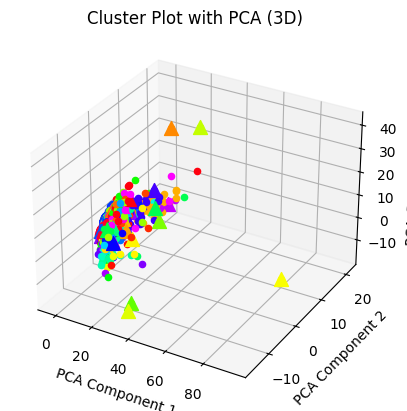

User 124363:
Closest centroid:  23
To Kill a Mockingbird;
The Lovely Bones: A Novel;
Summer Sisters;
Girl with a Pearl Earring;
The Divine Secrets of the Ya-Ya Sisterhood: A Novel;
The Pilot's Wife : A Novel;
Life of Pi;
House of Sand and Fog;
The Sweet Potato Queens' Book of Love;
The Red Tent (Bestselling Backlist)
User 6543:
Closest centroid:  23
To Kill a Mockingbird;
Girl with a Pearl Earring;
Summer Sisters;
The Divine Secrets of the Ya-Ya Sisterhood: A Novel;
The Pilot's Wife : A Novel;
Life of Pi;
Good in Bed;
House of Sand and Fog;
The Five People You Meet in Heaven;
The Nanny Diaries: A Novel
User 255092:
Closest centroid:  59
To Kill a Mockingbird;
Lord of the Flies;
Snow Falling on Cedars;
The Firm;
Harry Potter and the Chamber of Secrets (Book 2);
Needful Things;
The Lovely Bones: A Novel;
The Bean Trees;
Dude, Where's My Country?;
Four To Score (A Stephanie Plum Novel)
User 59150:
Closest centroid:  44
The Horse Whisperer;
The Vampire Lestat (Vampire Chronicles, Book II);

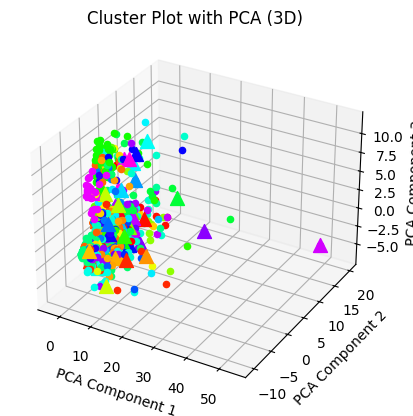

User 124363:
Closest centroid:  68
The Divine Secrets of the Ya-Ya Sisterhood: A Novel;
The No. 1 Ladies' Detective Agency (Today Show Book Club #8);
Cold Mountain : A Novel;
Little Altars Everywhere: A Novel;
Me Talk Pretty One Day;
Angels &amp; Demons;
The Nanny Diaries: A Novel;
Where the Heart Is (Oprah's Book Club (Paperback));
1st to Die: A Novel;
The Pilot's Wife : A Novel
User 6543:
Closest centroid:  54
Life of Pi;
Girl with a Pearl Earring;
The Pilot's Wife : A Novel;
Good in Bed;
The Joy Luck Club;
Message in a Bottle;
A Painted House;
The Kitchen God's Wife;
Summer Sisters;
The Divine Secrets of the Ya-Ya Sisterhood: A Novel
User 255092:
Closest centroid:  99
A Painted House;
The Summons;
Sphere;
Snow Falling on Cedars;
The Firm;
Along Came a Spider (Alex Cross Novels);
Where the Heart Is (Oprah's Book Club (Paperback));
Message in a Bottle;
The No. 1 Ladies' Detective Agency (Today Show Book Club #8);
Good in Bed
User 59150:
Closest centroid:  84
Silence of the Lambs;
Litt

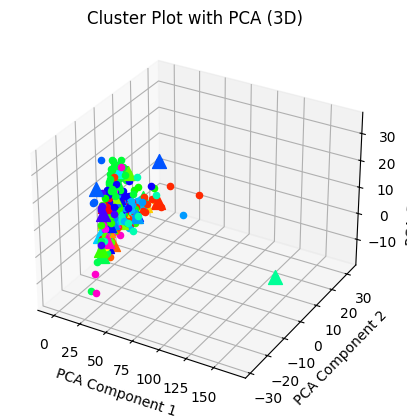

User 124363:
Closest centroid:  0
Interview with the Vampire;
Life of Pi;
Confessions of a Shopaholic (Summer Display Opportunity);
To Kill a Mockingbird;
Harry Potter and the Sorcerer's Stone (Harry Potter (Paperback));
The Red Tent (Bestselling Backlist);
Angels &amp; Demons;
Jurassic Park;
Where the Heart Is (Oprah's Book Club (Paperback));
The Five People You Meet in Heaven
User 6543:
Closest centroid:  0
Interview with the Vampire;
Life of Pi;
Confessions of a Shopaholic (Summer Display Opportunity);
To Kill a Mockingbird;
Harry Potter and the Sorcerer's Stone (Harry Potter (Paperback));
Good in Bed;
Angels &amp; Demons;
Jurassic Park;
Where the Heart Is (Oprah's Book Club (Paperback));
The Five People You Meet in Heaven
User 255092:
Closest centroid:  0
The Da Vinci Code;
The Secret Life of Bees;
Life of Pi;
Confessions of a Shopaholic (Summer Display Opportunity);
To Kill a Mockingbird;
Good in Bed;
The Red Tent (Bestselling Backlist);
Angels &amp; Demons;
Jurassic Park;
Where t

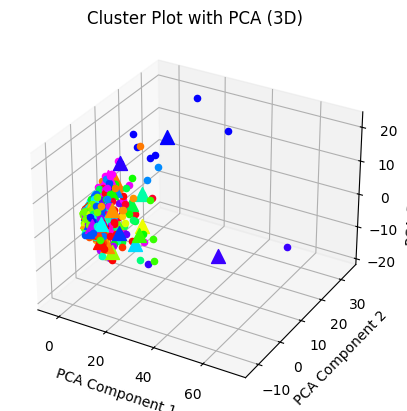

User 124363:
Closest centroid:  42
To Kill a Mockingbird;
The Notebook;
The Nanny Diaries: A Novel;
Divine Secrets of the Ya-Ya Sisterhood: A Novel;
Life of Pi;
The Hundred Secret Senses;
Neverwhere;
One for the Money (Stephanie Plum Novels (Paperback));
Girl in Hyacinth Blue;
The Rapture of Canaan
User 6543:
Closest centroid:  87
To Kill a Mockingbird;
Lord of the Flies;
The Catcher in the Rye;
Harry Potter and the Sorcerer's Stone (Harry Potter (Paperback));
The Bean Trees;
Silence of the Lambs;
Girl with a Pearl Earring;
The Bad Beginning (A Series of Unfortunate Events, Book 1);
Bel Canto: A Novel;
Life of Pi
User 255092:
Closest centroid:  28
Sphere;
Neverwhere;
Along Came a Spider (Alex Cross Novels);
Where the Heart Is (Oprah's Book Club (Paperback));
A Painted House;
Rising Sun;
Kiss the Girls;
American Gods;
Silence of the Lambs;
Hot Six : A Stephanie Plum Novel (A Stephanie Plum Novel)
User 59150:
Closest centroid:  98
Call of the Wild;
Watership Down;
Empire Falls;
The Reade

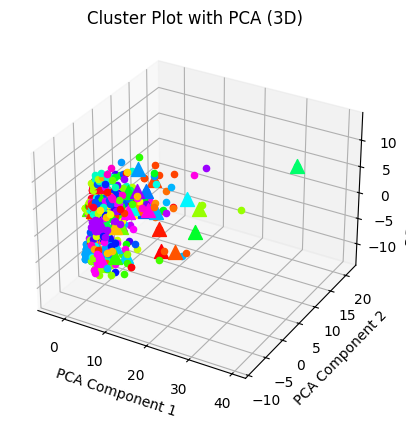

User 124363:
Closest centroid:  6
Life of Pi;
Girl with a Pearl Earring;
Summer Sisters;
She's Come Undone (Oprah's Book Club);
The Lovely Bones: A Novel;
House of Sand and Fog;
Message in a Bottle;
Wild Animus;
She's Come Undone (Oprah's Book Club (Paperback));
The Divine Secrets of the Ya-Ya Sisterhood: A Novel
User 6543:
Closest centroid:  20
Little Altars Everywhere: A Novel;
Into Thin Air : A Personal Account of the Mt. Everest Disaster;
Midwives: A Novel;
Divine Secrets of the Ya-Ya Sisterhood: A Novel;
Good in Bed;
Interview with the Vampire;
The Girls' Guide to Hunting and Fishing;
Life of Pi;
Red Dragon;
The Pilot's Wife : A Novel
User 255092:
Closest centroid:  69
The Nanny Diaries: A Novel;
STONES FROM THE RIVER;
A Is for Alibi (Kinsey Millhone Mysteries (Paperback));
Message in a Bottle;
She's Come Undone (Oprah's Book Club);
Good in Bed;
Red Dragon;
Wild Animus;
The Alienist;
Jurassic Park
User 59150:
Closest centroid:  77
The Pelican Brief;
The Runaway Jury;
Hannibal;
A P

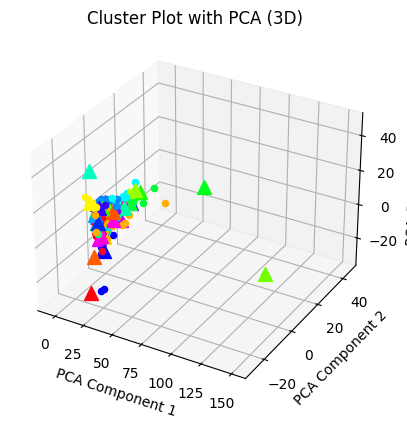

User 124363:
Closest centroid:  23
Eats, Shoots &amp; Leaves: The Zero Tolerance Approach to Punctuation;
The Devil Wears Prada : A Novel;
Sisterhood of the Traveling Pants;
Balzac and the Little Chinese Seamstress : A Novel;
Atonement : A Novel;
Three Junes;
The Blind Assassin;
A Map of the World;
Bleachers;
The King of Torts
User 6543:
Closest centroid:  0
Life of Pi;
Interview with the Vampire;
Good in Bed;
Angels &amp; Demons;
Harry Potter and the Sorcerer's Stone (Harry Potter (Paperback));
To Kill a Mockingbird;
Where the Heart Is (Oprah's Book Club (Paperback));
Girl with a Pearl Earring;
Divine Secrets of the Ya-Ya Sisterhood: A Novel;
The Pilot's Wife : A Novel
User 255092:
Closest centroid:  0
The Lovely Bones: A Novel;
The Da Vinci Code;
Life of Pi;
Good in Bed;
The Secret Life of Bees;
Angels &amp; Demons;
The Red Tent (Bestselling Backlist);
To Kill a Mockingbird;
Where the Heart Is (Oprah's Book Club (Paperback));
Girl with a Pearl Earring
User 59150:
Closest centroid:  0

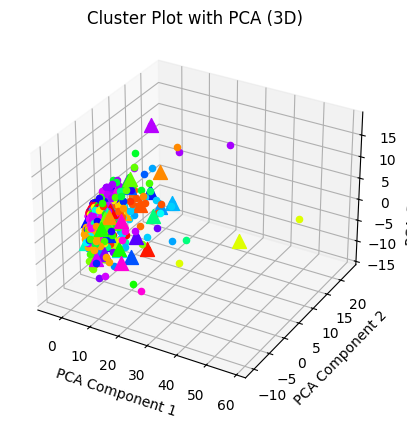

User 124363:
Closest centroid:  0
Where the Heart Is (Oprah's Book Club (Paperback));
Interview with the Vampire;
The Notebook;
Angels &amp; Demons;
Lord of the Flies;
The Client;
The Vampire Lestat (Vampire Chronicles, Book II);
The Nanny Diaries: A Novel;
Snow Falling on Cedars;
Lucky : A Memoir
User 6543:
Closest centroid:  78
To Kill a Mockingbird;
Nickel and Dimed: On (Not) Getting By in America;
Snow Falling on Cedars;
A Is for Alibi (Kinsey Millhone Mysteries (Paperback));
Into Thin Air : A Personal Account of the Mt. Everest Disaster;
The Queen of the Damned (Vampire Chronicles (Paperback));
The Divine Secrets of the Ya-Ya Sisterhood: A Novel;
Confessions of an Ugly Stepsister : A Novel;
Lord of the Flies;
Red Dragon
User 255092:
Closest centroid:  63
Along Came a Spider (Alex Cross Novels);
To Kill a Mockingbird;
The Red Tent (Bestselling Backlist);
Silence of the Lambs;
The Da Vinci Code;
The Reader;
The Handmaid's Tale;
The Prince of Tides;
Sphere;
The Vampire Lestat (Vampir

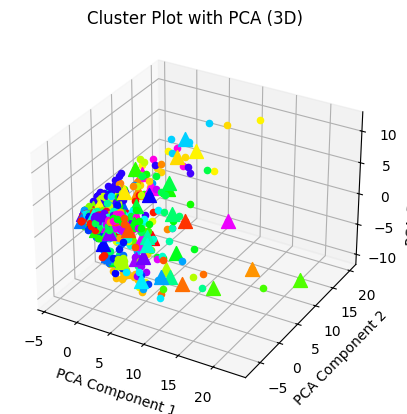

User 124363:
Closest centroid:  73
To Kill a Mockingbird;
Snow Falling on Cedars;
A Painted House;
Interview with the Vampire;
Life of Pi;
Red Dragon;
She's Come Undone (Oprah's Book Club (Paperback));
Angels &amp; Demons;
Divine Secrets of the Ya-Ya Sisterhood: A Novel;
1st to Die: A Novel
User 6543:
Closest centroid:  73
To Kill a Mockingbird;
Snow Falling on Cedars;
A Painted House;
Interview with the Vampire;
Life of Pi;
Red Dragon;
She's Come Undone (Oprah's Book Club (Paperback));
Angels &amp; Demons;
Divine Secrets of the Ya-Ya Sisterhood: A Novel;
Midwives: A Novel
User 255092:
Closest centroid:  64
The Da Vinci Code;
A Painted House;
Girl with a Pearl Earring;
The Notebook;
Good in Bed;
Little Altars Everywhere: A Novel;
The Secret Life of Bees;
The Bridges of Madison County;
House of Sand and Fog;
Snow Falling on Cedars
User 59150:
Closest centroid:  82
Snow Falling on Cedars;
Midwives: A Novel;
The Pelican Brief;
She's Come Undone (Oprah's Book Club);
The Perfect Storm : A T

In [34]:
all_recommendations_kmeans = {}
all_clusters_kmeans = {}

for min_user_ratings in min_user_ratings_values:
    for min_book_ratings in min_book_ratings_values:
        print(f"\nPredictions for min_user_ratings = {min_user_ratings}, min_book_ratings = {min_book_ratings}\n")
        user_book_ratings = get_pivot_table(min_user_ratings, min_book_ratings)
        print(user_book_ratings)
        clusters, centroids = KMeans(user_book_ratings, 100)
        all_clusters_kmeans[(min_user_ratings, min_book_ratings)] = (clusters, centroids)
        plot_clusters(clusters, centroids)
        recommendations = make_recommendation(centroids)

        all_recommendations_kmeans[(min_user_ratings, min_book_ratings)] = recommendations